In [1]:
import os
import sys
import pandas as pd
import numpy as np

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path

sys.path.append(parent_dir)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import bernoulli
sns.set_theme()
sns.set_style("whitegrid")

In [3]:
from utils import train_fairness_classifiers

from src.data_utils import joint_distribution
from src.analyze_metric_sensitivity import analyze_metric_sensitivity

In [4]:
ds = np.load("/Users/njwfish/Dropbox/Testing_fairness/data/adult.abroca.npz")
X, y, A = ds["X"], ds["y"], ds["A"]

perm = np.random.choice(y.shape[0], size=(y.shape[0],), replace=False)
prop = int(0.5 * y.shape[0])

X_train, y_train, A_train = X[perm][:-prop], y[perm][:-prop], A[perm][:-prop]
X_test, y_test, A_test = X[perm][-prop:], y[perm][-prop:], A[perm][-prop:]

In [5]:
ecp_cf = {
    "dag_str": "A->Y,A->P,A->T,T->Y,U->Y,U->P,V->T,V->P,W->T,W->Y",
    "unob": ["U", "W", "V"],
    "constraints": ["P(Y(T=1)=1&Y(T=0)=0) + P(Y(T=1)=0&Y(T=0)=1) <=  D"],
    "cond_nodes": None,
    "attribute_node": "A",
    "outcome_node": "Y(T=1)",
    "prediction_node": "P"
}
ecp_mt_cf = {
    "dag_str": "A->Y,A->P,A->T,T->Y,U->Y,U->P,V->T,V->P,W->T,W->Y",
    "unob": ["U", "W", "V"],
    "constraints": ["P(Y(T=1)=0&Y(T=0)=1) == 0", "P(Y(T=1)=1&Y(T=0)=0) <= D"],
    "cond_nodes": None,
    "attribute_node": "A",
    "outcome_node": "Y(T=1)",
    "prediction_node": "P"
}

/Users/njwfish/fragile.ml/.conda/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/njwfish/fragile.ml/.conda/lib/python3.11

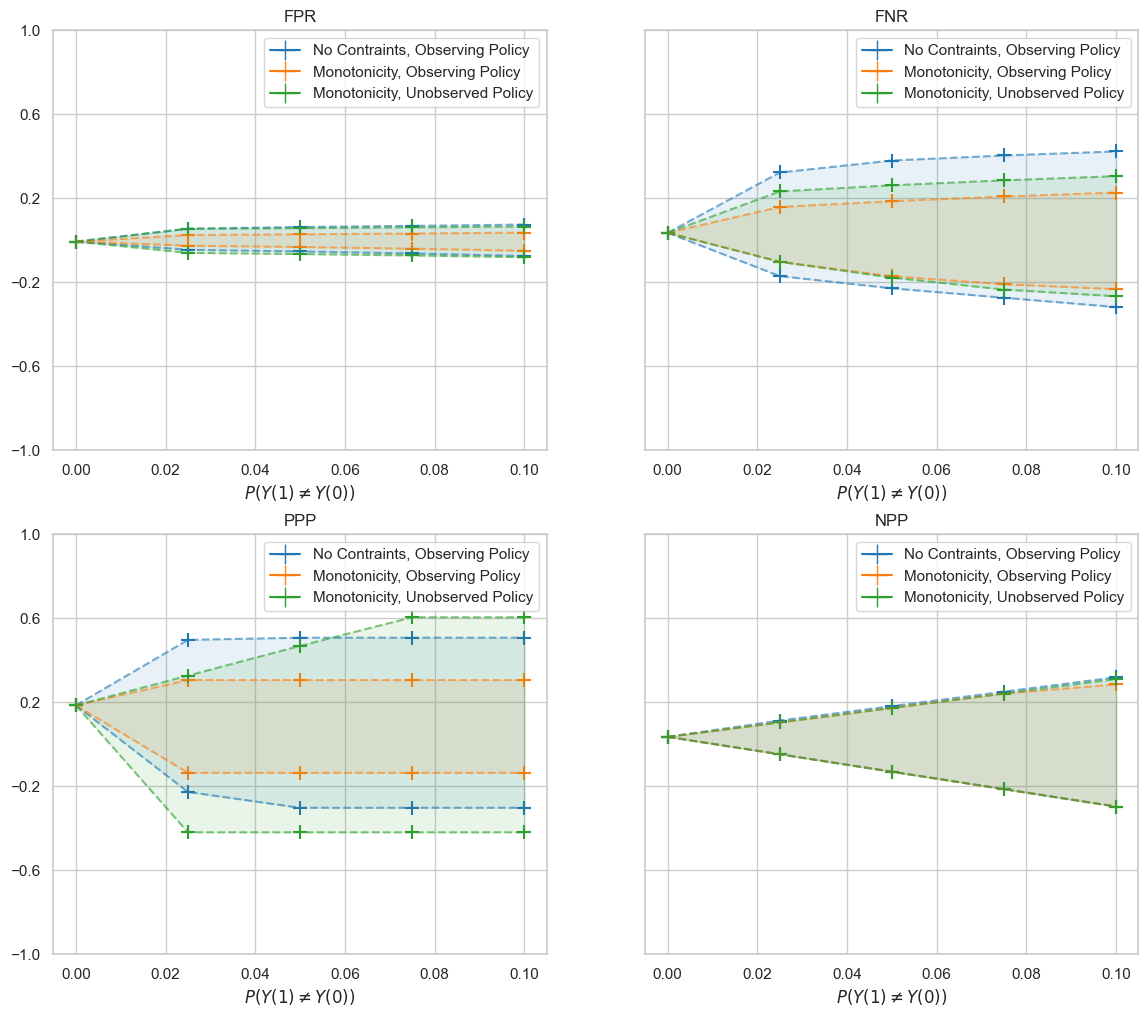

In [6]:
colours = sns.color_palette("tab10", 4)

fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize= (14, 12))
ax = ax.reshape(4)

metrics = ["FPR", "FNR", "PPP", "NPP"]
constraints = [(ecp_cf, True), (ecp_mt_cf, True), (ecp_mt_cf, False)]
labels = ["No Contraints, Observing Policy", "Monotonicity, Observing Policy", "Monotonicity, Unobserved Policy"]
range_ab = np.linspace(0, 0.1, 5)
lines = []

for j, metric in enumerate(metrics):
    predictor = train_fairness_classifiers(X_train, y_train, A_train, disparity_metric=metric)[0]
    c = 0.2
    T = (np.random.random(len(A)) > 1/2- c*A).astype(int)
    T_test = T[perm][-prop:]
    df = pd.DataFrame({
        "A": A_test, "Y": y_test, "P": predictor.predict(X_test), "T": T_test
    })
    prob_df_T = joint_distribution(df, ["A", "Y", "P", "T"])
    prob_df_no_T = joint_distribution(df, ["A", "Y", "P"])
    for i, (config, include_T) in enumerate(constraints):
        lower_results = []
        upper_results = []

        for val in range_ab:
            prob_df = prob_df_T if include_T else prob_df_no_T
            sens_results = analyze_metric_sensitivity(
                prob_df, metric, sensitivity_parameter_values=val, **config
            )
            # print(metric, val, include_T, sens_results)
            lower_results.append(sens_results[0])
            upper_results.append(sens_results[1])

        ax[j].fill_between(range_ab, lower_results, upper_results, alpha=.1,color = colours[i])
        ax[j].plot(range_ab, upper_results, ls='--', alpha=.6,color=colours[i])
        ax[j].plot(range_ab, lower_results, ls='--', alpha=.6,color=colours[i])

        ax[j].scatter(range_ab, upper_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
        ax[j].scatter(range_ab, lower_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])

    legend_elements = [Line2D([0], [0], marker='+', color=colours[0], label='Scatter',
                            markerfacecolor='b', markersize=15),
                        Line2D([0], [0], marker='+', color=colours[1], label='Scatter',
                            markerfacecolor='b', markersize=15),
                        Line2D([0], [0], marker='+', color=colours[2], label='Scatter',
                            markerfacecolor='b', markersize=15)]

    ax[j].legend(handles = legend_elements,labels = labels)
    ax[j].set_yticks(np.arange(-1, 1.2, 0.4))
    ax[j].set_xlabel(r"$P(Y(1) \neq Y(0))$")
    ax[j].set_title(metric)